In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [163]:
df = pd.read_csv("ecommercedata.csv", encoding="latin-1")

In [164]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [206]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], dayfirst=True)
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]

print("Number of rows after cleaning:", len(df))

Number of rows after cleaning: 530104


In [207]:
df["LineTotal"] = df["Quantity"] * df["UnitPrice"]
df["InvoiceYear"] = df["InvoiceDate"].dt.year
df["InvoiceMonth"] = df["InvoiceDate"].dt.month
df["InvoiceWeek"] = df["InvoiceDate"].dt.isocalendar().week.astype(int)

df[["InvoiceDate", "InvoiceYear", "InvoiceMonth", "InvoiceWeek", "LineTotal"]].head()

,InvoiceDate,InvoiceYear,InvoiceMonth,InvoiceWeek,LineTotal
0,2010-12-01 08:26:00,2010,12,48,15.30
1,2010-12-01 08:26:00,2010,12,48,20.34
2,2010-12-01 08:26:00,2010,12,48,22.00
3,2010-12-01 08:26:00,2010,12,48,20.34
4,2010-12-01 08:26:00,2010,12,48,20.34


In [208]:
reference_date = df["InvoiceDate"].max()
print("Reference date:", reference_date)

Reference date: 2011-12-09 12:50:00


In [209]:
product_last_sale = (
    df.groupby("StockCode")["InvoiceDate"]
      .max()
      .reset_index()
      .rename(columns={"InvoiceDate": "last_sale_date"})
)

In [210]:
product_last_sale["days_since_last_sale"] = (
    reference_date - product_last_sale["last_sale_date"]
).dt.days

In [211]:
THRESHOLD_DAYS = 90

In [212]:
product_last_sale["dead_stock_label"] = (
    product_last_sale["days_since_last_sale"] > THRESHOLD_DAYS
).astype(int)

In [213]:
print(product_last_sale.head())
print("\nDead stock label counts (0 = active, 1 = dead stock):")
print(product_last_sale["dead_stock_label"].value_counts())

  StockCode      last_sale_date  days_since_last_sale  dead_stock_label
0     10002 2011-04-18 12:56:00                   234                 1
1     10080 2011-11-21 17:04:00                    17                 0
2     10120 2011-12-04 13:15:00                     4                 0
3    10123C 2011-03-31 13:14:00                   252                 1
4    10124A 2011-11-06 13:00:00                    32                 0

Dead stock label counts (0 = active, 1 = dead stock):
dead_stock_label
0    3234
1     688
Name: count, dtype: int64


In [214]:
product_agg = (
    df.groupby("StockCode")
      .agg(
          total_quantity_sold=("Quantity", "sum"),
          num_invoices=("InvoiceNo", "nunique"),
          first_sale_date=("InvoiceDate", "min"),
          avg_unit_price=("UnitPrice", "mean"),
          total_revenue=("LineTotal", "sum")
      )
      .reset_index()
)

In [215]:
print("Product-level aggregation sample:")
print(product_agg.head())

Product-level aggregation sample:
  StockCode  total_quantity_sold  num_invoices     first_sale_date  \
0     10002                  860            71 2010-12-01 08:45:00   
1     10080                  303            22 2011-02-27 13:47:00   
2     10120                  193            29 2010-12-03 11:19:00   
3    10123C                    5             3 2010-12-03 11:19:00   
4    10124A                   16             5 2010-12-06 13:13:00   

   avg_unit_price  total_revenue  
0        1.086620         759.89  
1        0.410909         119.09  
2        0.210000          40.53  
3        0.650000           3.25  
4        0.420000           6.72  


In [216]:
product_dataset = product_agg.merge(
    product_last_sale[["StockCode", "last_sale_date", "days_since_last_sale", "dead_stock_label"]],
    on="StockCode",
    how="left"
)

In [217]:
product_dataset["active_days"] = (
    product_dataset["last_sale_date"] - product_dataset["first_sale_date"]
).dt.days


In [218]:
print("Number of products before filtering:", len(product_dataset))
print("\nDead stock label counts:")
print(product_dataset["dead_stock_label"].value_counts())
product_dataset.head()

Number of products before filtering: 3922

Dead stock label counts:
dead_stock_label
0    3234
1     688
Name: count, dtype: int64


,StockCode,total_quantity_sold,num_invoices,first_sale_date,avg_unit_price,total_revenue,last_sale_date,days_since_last_sale,dead_stock_label,active_days
0,10002,860,71,2010-12-01 08:45:00,1.086620,759.89,2011-04-18 12:56:00,234,1,138
1,10080,303,22,2011-02-27 13:47:00,0.410909,119.09,2011-11-21 17:04:00,17,0,267
2,10120,193,29,2010-12-03 11:19:00,0.210000,40.53,2011-12-04 13:15:00,4,0,366
3,10123C,5,3,2010-12-03 11:19:00,0.650000,3.25,2011-03-31 13:14:00,252,1,118
4,10124A,16,5,2010-12-06 13:13:00,0.420000,6.72,2011-11-06 13:00:00,32,0,334


In [219]:
min_invoices = 3
product_dataset = product_dataset[product_dataset["num_invoices"] >= min_invoices]

In [220]:
print("Number of products after filtering:", len(product_dataset))
print("\nDead stock label counts after filtering:")
print(product_dataset["dead_stock_label"].value_counts())
product_dataset.head()

Number of products after filtering: 3640

Dead stock label counts after filtering:
dead_stock_label
0    3164
1     476
Name: count, dtype: int64


,StockCode,total_quantity_sold,num_invoices,first_sale_date,avg_unit_price,total_revenue,last_sale_date,days_since_last_sale,dead_stock_label,active_days
0,10002,860,71,2010-12-01 08:45:00,1.086620,759.89,2011-04-18 12:56:00,234,1,138
1,10080,303,22,2011-02-27 13:47:00,0.410909,119.09,2011-11-21 17:04:00,17,0,267
2,10120,193,29,2010-12-03 11:19:00,0.210000,40.53,2011-12-04 13:15:00,4,0,366
3,10123C,5,3,2010-12-03 11:19:00,0.650000,3.25,2011-03-31 13:14:00,252,1,118
4,10124A,16,5,2010-12-06 13:13:00,0.420000,6.72,2011-11-06 13:00:00,32,0,334


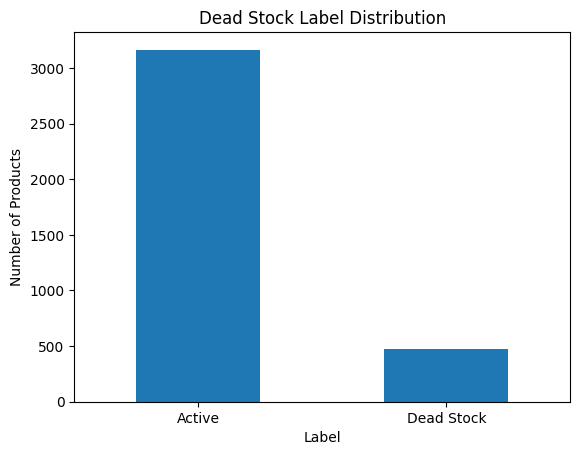

In [221]:
product_dataset["dead_stock_label"].value_counts().plot(kind="bar")
plt.xticks([0, 1], ["Active", "Dead Stock"], rotation=0)
plt.title("Dead Stock Label Distribution")
plt.xlabel("Label")
plt.ylabel("Number of Products")
plt.show()

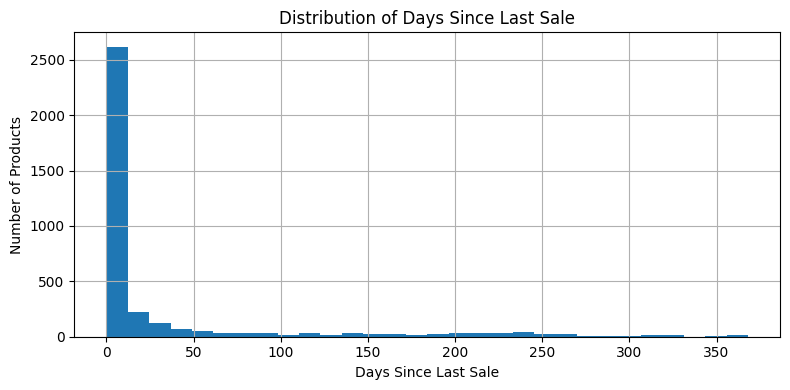

In [223]:
product_dataset["days_since_last_sale"].hist(bins=30, figsize=(8, 4))
plt.title("Distribution of Days Since Last Sale")
plt.xlabel("Days Since Last Sale")
plt.ylabel("Number of Products")
plt.tight_layout()
plt.show()

In [224]:
feature_cols = [
    "total_quantity_sold",
    "num_invoices",
    "avg_unit_price",
    "total_revenue",
    "active_days",
    "days_since_last_sale"
]


In [226]:
x = product_dataset[feature_cols]
y = product_dataset["dead_stock_label"]

In [227]:
print("X shape:", x.shape)
print("y shape:", y.shape)

X shape: (3640, 6)
y shape: (3640,)


In [229]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", x_train.shape[0])
print("Test size :", x_test.shape[0])

Train size: 2912
Test size : 728


In [230]:
dt_clf = DecisionTreeClassifier(
    max_depth=5,
    random_state=42
)
dt_clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [231]:
y_pred = dt_clf.predict(x_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       633
           1       1.00      1.00      1.00        95

    accuracy                           1.00       728
   macro avg       1.00      1.00      1.00       728
weighted avg       1.00      1.00      1.00       728


Confusion Matrix:
[[633   0]
 [  0  95]]


In [232]:
importances = dt_clf.feature_importances_

feat_imp = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_imp)


                feature  importance
5  days_since_last_sale         1.0
0   total_quantity_sold         0.0
1          num_invoices         0.0
2        avg_unit_price         0.0
3         total_revenue         0.0
4           active_days         0.0


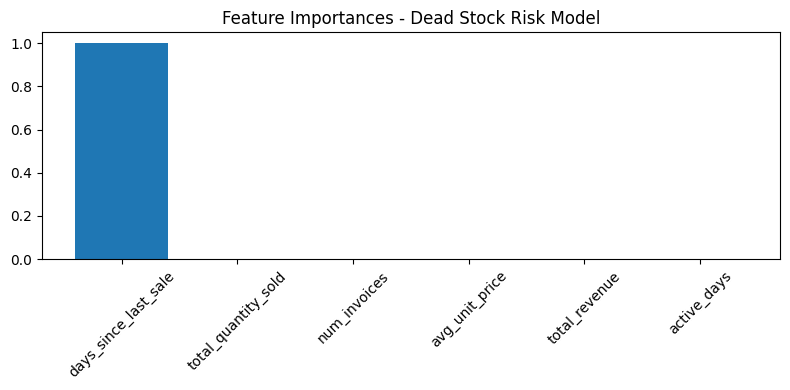

In [233]:
plt.figure(figsize=(8, 4))
plt.bar(feat_imp["feature"], feat_imp["importance"])
plt.xticks(rotation=45)
plt.title("Feature Importances - Dead Stock Risk Model")
plt.tight_layout()
plt.show()

In [234]:
x_full = product_dataset[feature_cols]

product_dataset["dead_stock_risk_score"] = dt_clf.predict_proba(x_full)[:, 1]

In [235]:
risk_table = product_dataset.sort_values(
    by="dead_stock_risk_score",
    ascending=False
)[["StockCode", "dead_stock_label", "dead_stock_risk_score",
   "total_quantity_sold", "num_invoices", "total_revenue", "days_since_last_sale"]]

risk_table.head(10)

,StockCode,dead_stock_label,dead_stock_risk_score,total_quantity_sold,num_invoices,total_revenue,days_since_last_sale
3082,84685,1,1.0,34,21,177.33,201
3083,84686,1,1.0,49,8,66.39,151
3085,84688,1,1.0,41,15,203.07,210
3087,84691,1,1.0,242,4,174.50,192
3504,85215,1,1.0,223,18,180.71,120
3503,85214,1,1.0,164,58,271.04,120
3502,85213,1,1.0,841,33,334.03,131
3090,84706D,1,1.0,8,4,29.60,201
3638,90062,1,1.0,44,26,558.03,224
3497,85206A,1,1.0,976,114,1572.23,266


In [236]:
def suggest_action(row):
    score = row["dead_stock_risk_score"]

    if score >= 0.8:
        return "Aggressive discount / bundling / consider liquidation"
    elif score >= 0.6:
        return "Run promotion and reduce future orders"
    elif score >= 0.4:
        return "Monitor closely and optimize pricing"
    else:
        return "Healthy stock"

product_dataset["inventory_action"] = product_dataset.apply(suggest_action, axis=1)

In [238]:
actions_table = product_dataset.sort_values(
    by="dead_stock_risk_score",
    ascending=False
)[["StockCode", "dead_stock_risk_score", "dead_stock_label",
   "total_quantity_sold", "num_invoices", "days_since_last_sale", "inventory_action"]]

actions_table

,StockCode,dead_stock_risk_score,dead_stock_label,total_quantity_sold,num_invoices,days_since_last_sale,inventory_action
3082,84685,1.0,1,34,21,201,Aggressive discount / bundling / consider liqu...
3083,84686,1.0,1,49,8,151,Aggressive discount / bundling / consider liqu...
3085,84688,1.0,1,41,15,210,Aggressive discount / bundling / consider liqu...
3087,84691,1.0,1,242,4,192,Aggressive discount / bundling / consider liqu...
3504,85215,1.0,1,223,18,120,Aggressive discount / bundling / consider liqu...
...,...,...,...,...,...,...,...
1373,22491,0.0,0,3959,219,0,Healthy stock
1374,22492,0.0,0,26633,380,0,Healthy stock
1375,22493,0.0,0,2463,220,0,Healthy stock
1376,22494,0.0,0,1089,245,1,Healthy stock


In [239]:
actions_table.to_csv("dead_stock_actions_table.csv", index=False)
print("Saved: dead_stock_actions_table.csv")

Saved: dead_stock_actions_table.csv
